In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import bisect
import matplotlib.pyplot as plt

In [2]:
# to ensure reproducibility
np.random.seed(100)

## SABR Model Simulation

Reference: <https://www.maths.univ-evry.fr/pages_perso/crepey/Equities/SABR.pdf>

Dynamics of SABR (stochastic-$\alpha\beta\rho$) model:

$$
\begin{align*}
dF_t &= \alpha_t F_t^\beta dW_t^1 \\
d\alpha_t &= \nu \alpha_t dW_t^2
\end{align*}
$$
where $W_t^i \sim \mathcal{N}(0, t)$, and $dW_t^1dW_t^2 = \rho dt$.  $F_t$ is the forward price of an underlying asset, and the parameters we want to estimate from data are $\nu, \beta$ and $\rho$.

For now, suppose the parameters $[\nu, \beta, \rho]$ and $F_0, \alpha_0$ are given.  Let $C_t(K, T)$ be the time-$t$  European call price of the forward with strike $K$ and maturity $T$.  We would like to study the Monte Carlo simulation of the forward price, and the implied volatilities of European call options across different moneyness.

Let $[\nu, \beta, \rho] = [1.0, 1.0, 0.5]$, $F_0 = 100, \alpha_0 = 20\%$.

In [3]:
nu, beta, rho = 1.0, 1.0, 0.5
F0, alpha0 = 100, 0.2
T = 1

### The forward price

Since $F_t$ is a martingale, at time 0, $F_T = F_0 = 100$.  But let's assume we don't know $F_T$, and estimate it by Monte Carlo simulation.

We can use the Euler method to simulate $F_t, \alpha_t$:
$$
\begin{align*}
F_{t+\Delta t} &= F_t + \alpha_t F_t^\beta (W_{t+\Delta t}^1 - W_t^1) &= F_t + \alpha_t F_t^\beta \Delta W_t^1 \\
\alpha_{t+\Delta t} &= \alpha_t + \nu \alpha_t (W_{t+\Delta t}^2 - W_t^2) &= \alpha_t + \nu \alpha_t \Delta W_t^2,
\end{align*}
$$
where $Cov(\Delta W_t^1, \Delta W_t^2) = \rho \Delta t$.

In matrix form,
$$
\begin{bmatrix}
    F_{t+\Delta t} \\ \alpha_{t+\Delta t}
\end{bmatrix}
= 
\begin{bmatrix}
    F_t \\ \alpha_t
\end{bmatrix}
+
\begin{bmatrix}
    \alpha_t F_t & 0 \\
    0 & \nu \alpha_t
\end{bmatrix}
\begin{bmatrix}
    \Delta W_t^1 \\ \Delta W_t^2
\end{bmatrix}.
$$
For convenience of notation, denote 
$$
\begin{align*}
    \theta_t &= [F_t,\alpha_t]^\intercal, \\
    A_t &=
    \begin{bmatrix}
        \alpha_t F_t & 0 \\
        0 & \nu \alpha_t
    \end{bmatrix}, \\
    \Delta W_t &= [\Delta W_t^1, \Delta W_t^2]^\intercal,
\end{align*}
$$
so the vectorized formula is
$$
    \theta_{t+\Delta t} = \theta_t + A_t \Delta W_t.
$$
We are interested in $\theta_T$.

In [4]:
# correlation matrix of BM
Rho = np.array([[1.0, rho],
                [rho, 1.0]])

# set other parameters
N = 100
deltat = T/N

# set number of Monte Carlo simulations
M = 100000

# save results
res = []

# covariance matrix and cholesky decomposition
Sigma = Rho * deltat
L = np.linalg.cholesky(Sigma)

for i in range(M):
    # one simulation
    theta = np.array([F0, alpha0])
    for t in range(1, N+1):
        # simulate two standard normal with covariance Sigma
        dW = L @ np.random.normal(0, 1, 2)
        # find A
        A = np.array([[theta[0]  *theta[1], 0],
                      [0, nu * theta[1]]])
        theta += A @ dW
    res.append(theta[0])

res = np.array(res)

In [5]:
res = np.array(res)

In [6]:
np.mean(res)

99.66858839666122

In [7]:
np.std(res) / np.sqrt(M)

0.14527812099029214

Indeed, the mean $E^{MC}(F_T) = \frac{1}{M} \sum_{i=1}^M \hat{F}_T^{(i)}$ from simulation is 99.67, which is around its true value 100.  The estimate has a standard deviation of around 0.15, and the time taken is already long, so we need to apply some variance reduction techniques if we really want to use simulation in real-time.

### The call price across different strikes

Assume zero risk-free rate, and define moneyness as $m := \log(F_0/K)$.  We want to plot the BS implied volatilities across different moneyness, by varying $K$.  Then 
$$
K = F_0 e^{-m}.
$$

In [8]:
moneyness = np.linspace(-2, 2, 100)
Ks = F0 * np.exp(-moneyness)

In [9]:
def BS_call(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 1/2 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [10]:
def simulate_call_prc(K):
    res = []

    # covariance matrix and cholesky decomposition
    Sigma = Rho * deltat
    L = np.linalg.cholesky(Sigma)

    for i in range(M):
        # one simulation
        theta = np.array([F0, alpha0])
        for t in range(1, N+1):
            # simulate two standard normal with covariance Sigma
            dW = L @ np.random.normal(0, 1, 2)
            # find A
            A = np.array([[theta[0]  *theta[1], 0],
                          [0, nu * theta[1]]])
            theta += A @ dW
        res.append(theta[0])
    
    res = np.array(res)
    
    return np.mean(np.maximum(res - K, 0))

In [11]:
# generate a list of call prices under different Ks
# for now set Monte Carlo parameter as 10000
# beware: this is going to take a long time
M = 10000
call_prices = np.array([ simulate_call_prc(K) for K in Ks ])

In [12]:
imp_vols = []
for i, K in enumerate(Ks):
    c = call_prices[i]
    try:
        imp_vol = bisect(lambda x: BS_call(F0, K, 0, x, T) - c, 1e-2, 1)
    except ValueError as e:
        imp_vol = None
    imp_vols.append(imp_vol)
imp_vols = np.array(imp_vols)

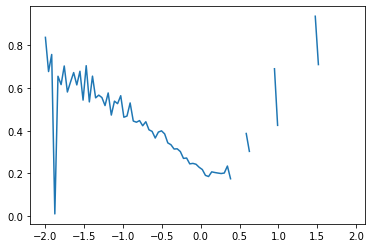

In [13]:
plt.plot(moneyness, imp_vols)
plt.show()

There are a lot of zig-zags because of large estimation errors caused by a small $M$ in Monte Carlo.  In the SABR paper, there is actually an analytical formula for implied volatility so we can compare the results from our simulations with that generated from the formula.  Let $f = F_0$ and $\alpha = \alpha_0$,

$$
\begin{align*}
    \sigma_B(K, f) = & \frac{\alpha}{(fK)^{(1-\beta)/2}\{ 1 + \frac{(1-\beta)^2}{24}\log^2f/K + \frac{(1-\beta)^4}{1920}\log^4f/K + \cdots \}} \cdot \left( \frac{z}{x(z)} \right) \cdot \\
    & \left\{ 1 + \left[ \frac{(1-\beta)^4}{24}\frac{\alpha^2}{(fK)^{1-\beta}} + \frac{1}{4} \frac{\rho\beta\nu\alpha}{(fK)^{(1-\beta)/2}} + \frac{2 - 3\rho^2}{24}\nu^2 \right] T + \cdots \right\},
\end{align*}
$$
where
$$
z = \frac{\nu}{\alpha} (fK)^{(1-\beta)/2} \log f/K,
$$
and
$$
x(z) = \log \left\{ \frac{ \sqrt{1 - 2\rho z + z^2} + z - \rho }{1 - \rho} \right\}.
$$

In [14]:
def x_func(z):
    return np.log( (np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho) )

def theo_impvol(K, f):
    first_term = alpha0 / ( (f*K)**((1-beta)/2) * (1 + (1-beta)**2/24 * np.log(f/K)**2 + 
                                                   (1-beta)**4/1920 * np.log(f/K)**4) )
    
    z = nu / alpha0 * (f*K)**((1-beta)/2) * np.log(f/K)
    second_term = z / x_func(z)
    
    third_term = 1 + ( (1-beta)**2/24 * alpha0**2/(f*K)**(1-beta) + 
                      1/4 * rho*beta*nu*alpha0/(f*K)**((1-beta)/2) + (2-3*rho**2)/24 * nu**2 ) * T
    
    return first_term * second_term * third_term

In [15]:
BS_impvols = np.array([ theo_impvol(K, F0) for K in Ks ])

Plotting simulated implied vol against theoretical vol:

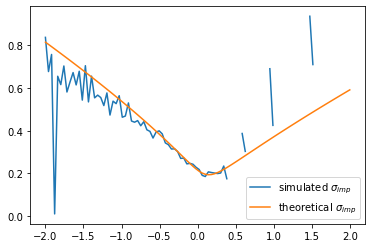

In [16]:
plt.plot(moneyness, imp_vols, label="simulated $\sigma_{imp}$")
plt.plot(moneyness, BS_impvols, label="theoretical $\sigma_{imp}$")
plt.legend()
plt.show()